# Design the withheld test set

Guidelines and things to bear in mind when creating a training/ testing split: 

Adapted from the google Data Prep and Feature Engineering In ML course:
https://developers.google.com/machine-learning/data-prep

__Size and quality__

- The size and quality of the dataset matters more than what model and training protocol is used. Garbage in, garbage out.
- As a rule of thumb, the model should train on at least one order of magnitude more examples than trainable parameters.

__Reliability__

- How common are label errors? If the dataset is labeled by humans, then how often do mistakes occur?
- Missing values
- Duplicated examples
- Mis-labeled examples
- Bad features (e.g low quality encoding)

During training, use only the features that you'll have available in serving, and make sure your training set is representative of your serving traffic.

- ### The Golden Rule: Do unto training as you would do unto prediction. 
That is, the more closely your training task matches your prediction task, the better your ML system will perform. Given this requirement, the osfl clips should be sliced out of the raw audio in the same manner as they would in production: otherwise there might end up being some artefacts present in the osfl examples which aren't present in the null class: for example, if a clip downloaded from wildtrax was 2s long and is extended to become 3s, then this could cause label leakage due to artefacts from the extension indicating the positive class. 




Steps to constructing a dataset
##### 1. Collect the raw data
Currently the raw data for the osfl song clips is downloaded, and the raw data for the no_song dataset is on AWS cloud servers. 
##### 2. Identify feature and label sources Features will be from the shapes in the spectrogram images. 
Labels are human labelled tags. 

##### 3. Select sampling strategy 
The chosen sampling strategy is to split the dataset by random sampling at the location_id level. 

##### 4. Split the data.

If data is restricted and a sample needs to be taken, ensure the data is spread out temporally, to reduce seasonal variation effects. Similarly ensure that the data comes from different locations to include spatial variation effects.

# A note on unbalanced data / class imbalance

Normally when there's a class imbalance in a dataset, the abundant class is downsampled, then examples from this class are weighted proportionally to the amount by which the class is downsampled. For example, if there are 100 case A for every 1 case B, then we might downsample case A by a factor of 10, so that the ratio of A to B is 10:1 instead of 100:1 in each mini batch.

To keep the model calibrated, we'd want to calculate the loss for examples in A as being 10 times as important as if we hadn't downsampled. This keeps the model's outputs calibrated in the sense that the outputs can still be treated as probabilities.

However, we're constructing an artificial dataset here. We can choose for the classes to be equally weighted: the 'song' clips can be exactly as numerous as the 'no-song' clips.

From the perspective of the model in deployment however, the ratio of song to no-song will be much different. Firstly because there is generally more silence than birdsong in the real environment. Another consideration is that if a signal detection algorithm is used, then this will filter out a lot of the silence, and change the class balance again depending on the features of the algorithm.

In addition, we don't need the actual probability that we detected a bird - only numbers proportional to the probability - since we can pick a threshold for the recognizer.

With all this considered, I've decided the simplest approach is to create an equally balanced dataset of song / no-song clips then train a model on these, and come back to the issue of class imbalance if it arises later. It is likely that the over-representation of olive sided flycatchers in a dataset of this type will need offsetting with weighting, under or oversampling, since it doesn't reflect the true ratio of classes found in production. 

### Train test split

- This should be smarter than a simple random shuffle of all the data, because a model can learn the specific background noises present at a location, then use this information, rather than the shape / sound of a bird's song, to make a prediction.

- It would be better to split the validation set from completely separate ARUs

- alternatives: split by day, split by project, split by location.

Once the data split has been decdied, download the relevant audio files and cut the audio segments from the downloaded files. If necessary, throw these away to save disk space, or do this in the cloud and download only the clips.

Throughout the data building phase, keep plotting scattergraphs and bar plots to make sure the distribution of the data matches expectations and is balanced.


Is the model just learning the acoustic signature of the ARUs which recorded an olive sided flycatcher?

It is important to make sure that the datasets contain positive and negative examples of recordings from the same ARUs to stop the model from learning a prediction such as 'if the background noise is like this, then predict olive sided flycatcher'. This could have been happening with the dummy datasets if the osfl clips tended to be clustered around certain ARUs and habitats, and the other vocalizations were from a more diverse spread of locations.


# Summary : test set requirements:
- The withheld test set should account for 20% of the osfl recordings found in the database. ~5000 total, 1000 to test on would give statistically significant results. 
- The test set should be split at the recording level rather than the audio segment level. This is to prevent data leakage in the form of neighbouring audio clips containing indicators of OSFL presence which wouldn't be accessable in production.
- The test set should be from as diverse area as possible. 


In [1]:
import sys
from pathlib import Path

BASE_PATH = Path.cwd().parents[1]
sys.path.append(str(BASE_PATH / "src" / "data"))  # for clean_csv
sys.path.append(str(BASE_PATH / "src"))  # for utils

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import clean_csv
from utils import *
import geopandas as gpd

In [2]:
# process the raw csv file (optional)
clean_csv.process_raw_csv()
%load_ext autoreload
%autoreload 2

Processing raw csv file...


/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/src/data/clean_csv.py:32: DtypeWarning: Columns (7,22) have mixed types. Specify dtype option on import or set low_memory=False.
  meta = pd.read_csv(data_path / "raw/TrainingData_BU&Public_CWS_with_rec_links.csv")


Done processing raw csv file. Outputted to data/interim/processed_metadata.csv + pkl


In [3]:
data_path = Path("../../data")
df_full = pd.read_pickle(data_path / "interim" / "processed_metadata.pkl")
df_full.columns

Index(['organization', 'project', 'project_id', 'location', 'location_id',
       'recording_date_time', 'recording_id', 'task_method', 'task_id',
       'aru_task_status', 'species_code', 'species_common_name',
       'species_scientific_name', 'species_class', 'detection_time',
       'task_duration', 'tag_duration', 'min_tag_freq', 'max_tag_freq',
       'tag_id', 'individual_order', 'vocalization', 'abundance', 'tag_rating',
       'tag_is_verified', 'clip_channel_used', 'observer', 'observer_id',
       'verifier_id', 'left_full_freq_tag_rms_peak_dbfs',
       'left_full_freq_tag_rms_trough_dbfs', 'left_full_freq_tag_pk_count',
       'left_full_freq_tag_dc_offset', 'left_full_freq_tag_min_level',
       'left_full_freq_tag_max_level', 'left_full_freq_tag_peak_level_dbfs',
       'left_freq_filter_tag_rms_peak_dbfs',
       'left_freq_filter_tag_rms_trough_dbfs', 'left_freq_filter_tag_pk_count',
       'left_freq_filter_tag_dc_offset', 'left_freq_filter_tag_min_level',
       'lef

In [4]:
keep_cols = [
    "organization",
    "project",
    "project_id",
    "location_id",
    "recording_id",
    "recording_date_time",
    "species_code",
    "species_common_name",
    "detection_time",
    "task_duration",
    "tag_duration",
    "tag_id",
    "clip_url",
    "recording_url",
    "latitude",
    "longitude",
    "file_type",
]
df = df_full[keep_cols]

In [5]:
display_all(df_full.head())

,organization,project,project_id,location,location_id,recording_date_time,recording_id,task_method,task_id,aru_task_status,species_code,species_common_name,species_scientific_name,species_class,detection_time,task_duration,tag_duration,min_tag_freq,max_tag_freq,tag_id,individual_order,vocalization,abundance,tag_rating,tag_is_verified,clip_channel_used,observer,observer_id,verifier_id,left_full_freq_tag_rms_peak_dbfs,left_full_freq_tag_rms_trough_dbfs,left_full_freq_tag_pk_count,left_full_freq_tag_dc_offset,left_full_freq_tag_min_level,left_full_freq_tag_max_level,left_full_freq_tag_peak_level_dbfs,left_freq_filter_tag_rms_peak_dbfs,left_freq_filter_tag_rms_trough_dbfs,left_freq_filter_tag_pk_count,left_freq_filter_tag_dc_offset,left_freq_filter_tag_min_level,left_freq_filter_tag_max_level,left_freq_filter_tag_peak_level_dbfs,right_full_freq_tag_rms_peak_dbfs,right_full_freq_tag_rms_trough_dbfs,right_full_freq_tag_pk_count,right_full_freq_tag_dc_offset,right_full_freq_tag_min_level,right_full_freq_tag_max_level,right_full_freq_tag_peak_level_dbfs,right_freq_filter_tag_rms_peak_dbfs,right_freq_filter_tag_rms_trough_dbfs,right_freq_filter_tag_pk_count,right_freq_filter_tag_dc_offset,right_freq_filter_tag_min_level,right_freq_filter_tag_max_level,right_freq_filter_tag_peak_level_dbfs,tagged_in_wildtrax,media_url,spectrogram_url,clip_url,sensorId,tasks,status,recording_url,latitude,longitude,location_buffer_m,file_type
1623,BU,Alberta Archetypes,1501,P-E0-1-10,308678,2022-06-05 06:51:00,416962,nan,596169,Transcribed,OVEN,Ovenbird,SEIURUS AUROCAPILLA,Aves,67.80,180.0,3.94,1.08kHz,11.38kHz,3212415,1.0,Song,1,NaN,f,1.0,Alex MacPhail,15,-1,-19.20,-45.60,2.0,0.000014,-0.392700,0.398468,-7.99,-19.21,-57.44,2.0,0.000000,-0.399567,0.387360,-7.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,https://portal.wildtrax.ca/home/aru-tasks/reco...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,ARU,357,Active,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,52.644040,-115.140510,NaN,flac
1752,BU,Amplitude Quality Testing 2020,293,AM-403-SE2,36043,2017-06-15 04:46:00,92051,nan,87956,Transcribed,LINO,Light continuous industrial noise,nan,Abiotic,0.00,180.0,4.05,0.00kHz,2.10kHz,1462249,1.0,Song,1,NaN,f,2.0,Brandon Law,22,-1,-31.23,-41.36,2.0,0.000032,-0.068624,0.064758,-23.27,-31.79,-42.37,2.0,0.000014,-0.053301,0.052177,-25.47,-29.25,-39.74,2.0,0.000028,-0.081295,0.076209,-21.80,-29.79,-40.60,2.0,0.000009,-0.069424,0.063139,-23.17,t,https://portal.wildtrax.ca/home/aru-tasks/reco...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,ARU,174,Published - Private,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,54.607774,-110.681271,NaN,flac
1758,BU,Amplitude Quality Testing 2020,293,AM-403-SE2,36043,2017-06-15 04:46:00,92051,nan,87898,Transcribed,OVEN,Ovenbird,SEIURUS AUROCAPILLA,Aves,0.04,180.0,2.65,2.57kHz,7.75kHz,1417508,1.0,Song,1,NaN,f,1.0,Scott Wilson,26,-1,-31.36,-38.68,2.0,0.000061,-0.072872,0.064519,-22.75,-40.70,-51.62,2.0,0.000000,-0.037936,0.035704,-28.42,-29.26,-36.63,2.0,0.000034,-0.081534,0.076978,-21.77,-39.50,-49.43,2.0,0.000000,-0.040386,0.036900,-27.88,t,https://portal.wildtrax.ca/home/aru-tasks/reco...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,ARU,174,Published - Private,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,54.607774,-110.681271,NaN,flac
1761,BU,Amplitude Quality Testing 2020,293,AM-403-SE2,36043,2017-06-15 04:46:00,92051,nan,87840,Transcribed,LIWI,Light wind,nan,Abiotic,0.05,180.0,6.54,0.05kHz,11.39kHz,1465125,1.0,Song,1,NaN,f,2.0,Jillian Slater,25,-1,-31.26,-41.46,2.0,0.000044,-0.066634,0.071793,-22.88,-34.11,-43.97,2.0,-0.000017,-0.053412,0.054215,-25.32,-29.18,-39.82,2.0,0.000016,-0.083415,0.086137,-21.30,-32.01,-42.38,2.0,-0.000010,-0.064721,0.062714,-23.78,t,https://portal.wildtrax.ca/home/aru-tasks/reco...,https://wildtrax-aru.s3.us-west-2.ama

### Check some assumptions about the data: 
### Assumption 1.
#####  all the clip ids are unique


In [6]:
assert df.tag_id.nunique() == len(df), "Duplicate tag ids found in database"
assert (
    df.recording_url.nunique() == df.recording_id.nunique()
), "Recording Ids and URLs have different numbers of unique values and therefore are not one to one mappings"

In [7]:
# How many of the target species will we throw out if we remove all recordings with missing urls?
sum(df.loc[df.recording_url == "nan"].species_code == "OSFL")

0

There were 46 osfl clips being filtered out through the removal of the recordings with missing URLS, from the Natural Disturbance Long Term Monitoring project. Since this removal logic was added to clean_csv.py the count is at zero. 



### Assumption 2: 
##### there is a one to one mapping between recording_id and recording_url

In [8]:
# Check for one to one mapping between recording id and recording url
def isOneToOne(df, col1, col2):
    first = df.groupby(col1)[col2].count().max()
    second = df.groupby(col2)[col1].count().max()
    return first + second == 2


isOneToOne(df, "recording_id", "recording_url")

False

In [9]:
(df.recording_id.value_counts().values - df.recording_url.value_counts().values).sum()

0

In [10]:
assert (
    len(df) == df.tag_id.nunique() == df.clip_url.nunique()
), "Duplicate tag ids found in database"
assert (
    df.recording_url.nunique() == df.recording_id.nunique()
), "Recording Ids and URLs have different numbers of unique values and therefore are not one to one mappings"

print(f"{df.recording_url.nunique()} recordings and {df.clip_url.nunique()} tags")

67926 recordings and 539731 tags


# To create a test set, select 20% of the data to remove from the dataset. 
This should be representative of the entire training dataset. Additionally we want to evaluate how the model will generalise to new locations. 
- To achieve this split, one option is to apply a grid to the map, and filter out 20% of the database at the recording level. Then make sure that the recordings which were selected also account for around 20% of the olive sided flycatcher clips. It might be necessary to split the data differently. 
- I decided against this grid technique due to the overall sparsity of the data, and the need to include as wide a variety of locations as possible in the training set. 

In [11]:
df.head()

,organization,project,project_id,location_id,recording_id,recording_date_time,species_code,species_common_name,detection_time,task_duration,tag_duration,tag_id,clip_url,recording_url,latitude,longitude,file_type
1623,BU,Alberta Archetypes,1501,308678,416962,2022-06-05 06:51:00,OVEN,Ovenbird,67.80,180.0,3.94,3212415,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,52.644040,-115.140510,flac
1752,BU,Amplitude Quality Testing 2020,293,36043,92051,2017-06-15 04:46:00,LINO,Light continuous industrial noise,0.00,180.0,4.05,1462249,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,54.607774,-110.681271,flac
1758,BU,Amplitude Quality Testing 2020,293,36043,92051,2017-06-15 04:46:00,OVEN,Ovenbird,0.04,180.0,2.65,1417508,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,54.607774,-110.681271,flac
1761,BU,Amplitude Quality Testing 2020,293,36043,92051,2017-06-15 04:46:00,LIWI,Light wind,0.05,180.0,6.54,1465125,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,54.607774,-110.681271,flac
1764,BU,Amplitude Quality Testing 2020,293,36043,92051,2017-06-15 04:46:00,LINO,Light continuous industrial noise,0.09,180.0,4.86,1569565,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,54.607774,-110.681271,flac


In [12]:
osfls = df.loc[df.species_code == "OSFL"]
len(osfls)

5039

### How many unique locations are there in the database?


In [13]:
df.location_id.nunique()

12604

### How many of those have olive sided flycatchers tagged?


In [14]:
osfls.location_id.nunique()

879

### How many unique recordings are there in the database?

In [15]:
df.recording_id.nunique(), osfls.recording_id.nunique()

(67926, 3542)

In [16]:
df.groupby("location_id").recording_id.nunique().sort_values(ascending=False)

location_id
98882     687
32109     399
58369     269
35086     161
35076     148
         ... 
220879      1
220878      1
220877      1
220876      1
480782      1
Name: recording_id, Length: 12604, dtype: int64

# plot this relationship between recording id and location id

<Axes: title={'center': 'Number of recordings per location in entire dataset'}, xlabel='Location ID', ylabel='Number of recordings'>

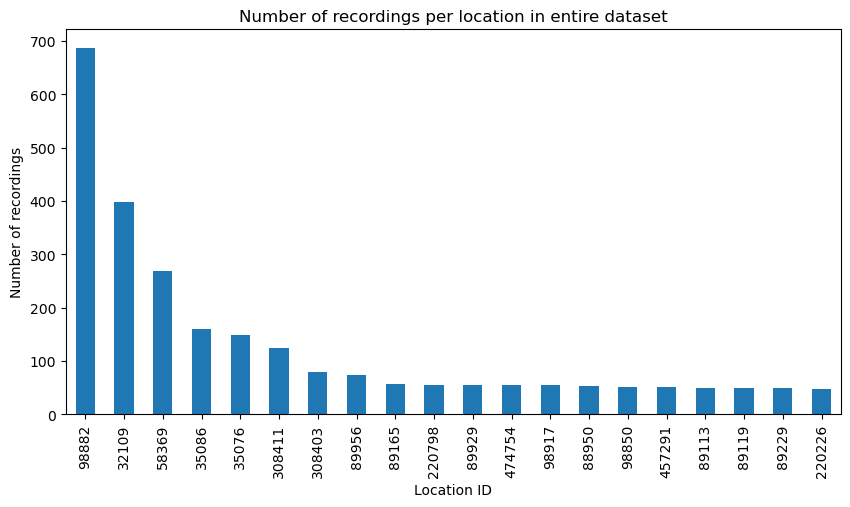

In [17]:
df.groupby("location_id").recording_id.nunique().sort_values(ascending=False)[:20].plot(
    kind="bar",
    figsize=(10, 5),
    title="Number of recordings per location in entire dataset",
    ylabel="Number of recordings",
    xlabel="Location ID",
)

### Distribution of recordings per location for entire df and for subset of df containing osfls

In [18]:
print("distribution of recording ID per locartion in entire dataset")
display(
    df.groupby("location_id")
    .recording_id.nunique()
    .sort_values(ascending=False)
    .describe()
)
print("distribution of recording ID per locartion in OSFL only dataset")
display(
    osfls.groupby("location_id")
    .recording_id.nunique()
    .sort_values(ascending=False)
    .describe()
)

distribution of recording ID per locartion in entire dataset


count    12604.000000
mean         5.389242
std         11.961430
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        687.000000
Name: recording_id, dtype: float64

distribution of recording ID per locartion in OSFL only dataset


count    879.000000
mean       4.029579
std        4.347024
min        1.000000
25%        1.000000
50%        2.000000
75%        5.000000
max       26.000000
Name: recording_id, dtype: float64

There are around 4 or 5 recordings per site on average in the database. 

<Axes: xlabel='location_id'>

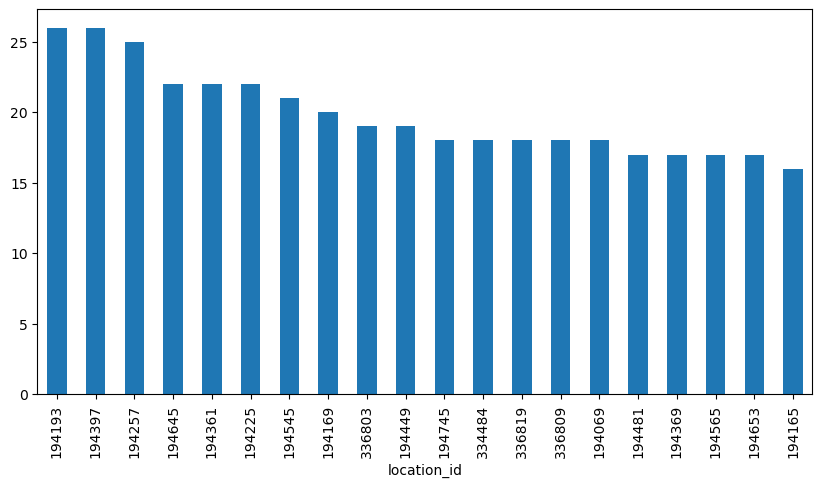

In [19]:
osfls.groupby("location_id").recording_id.nunique().sort_values(ascending=False)[
    :20
].plot(kind="bar", figsize=(10, 5))

In [20]:
# Take a random sample from 20% of the locations without replacement
from sklearn.model_selection import train_test_split

locations = df.location_id.unique()
train_locations, test_locations = train_test_split(
    locations, test_size=0.2, random_state=42
)

In [21]:
locations

array([308678,  36043,  35298, ...,  50665,  35171,  41031])

In [22]:
df_test = df.loc[df.location_id.isin(test_locations)]
df_train = df.loc[df.location_id.isin(train_locations)]
osfls_test = df_test.loc[df.species_code == "OSFL"]

/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/src/utils.py:50: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  canada = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres")).query(


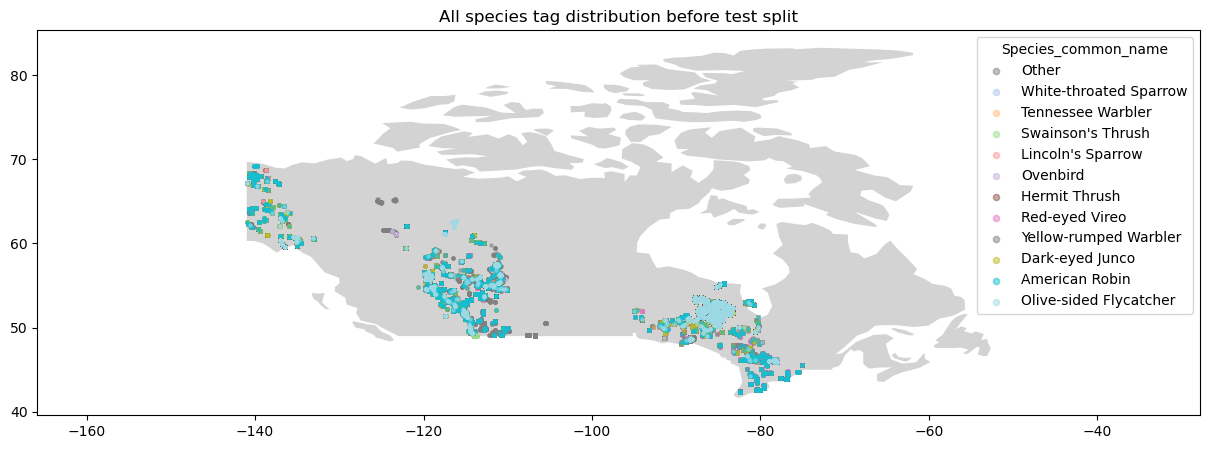

In [23]:
plot_locations(
    df,
    title="All species tag distribution before test split",
    feature="species_common_name",
    forced_features=["Olive-sided Flycatcher"],
)

In [24]:
df.loc[df.longitude > 0]

,organization,project,project_id,location_id,recording_id,recording_date_time,species_code,species_common_name,detection_time,task_duration,tag_duration,tag_id,clip_url,recording_url,latitude,longitude,file_type


/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/src/utils.py:50: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  canada = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres")).query(
/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/src/utils.py:74: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  points.plot(
/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/src/utils.py:74: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  points.plot(


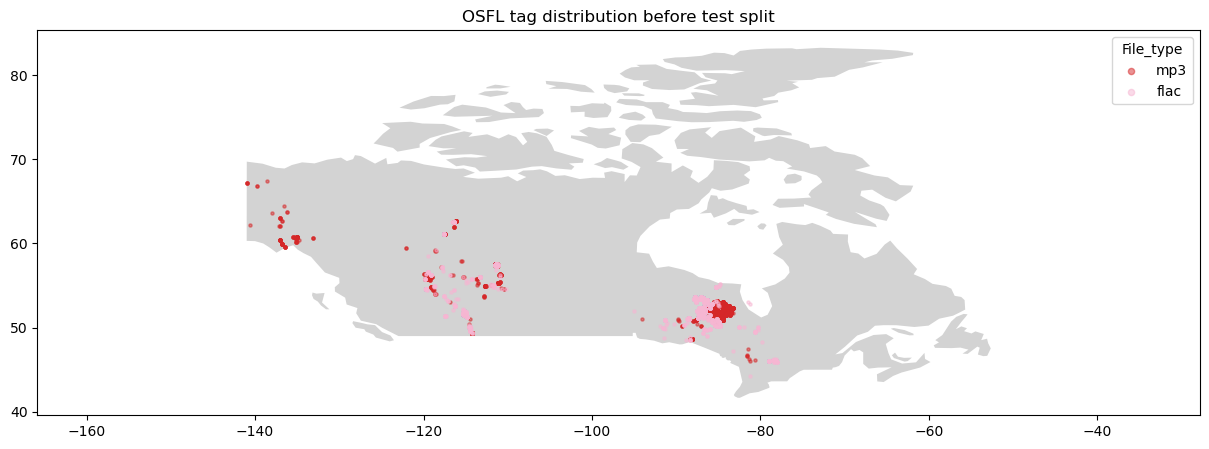

In [25]:
plot_locations(
    osfls, title="OSFL tag distribution before test split", feature="file_type"
)

/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/src/utils.py:50: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  canada = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres")).query(


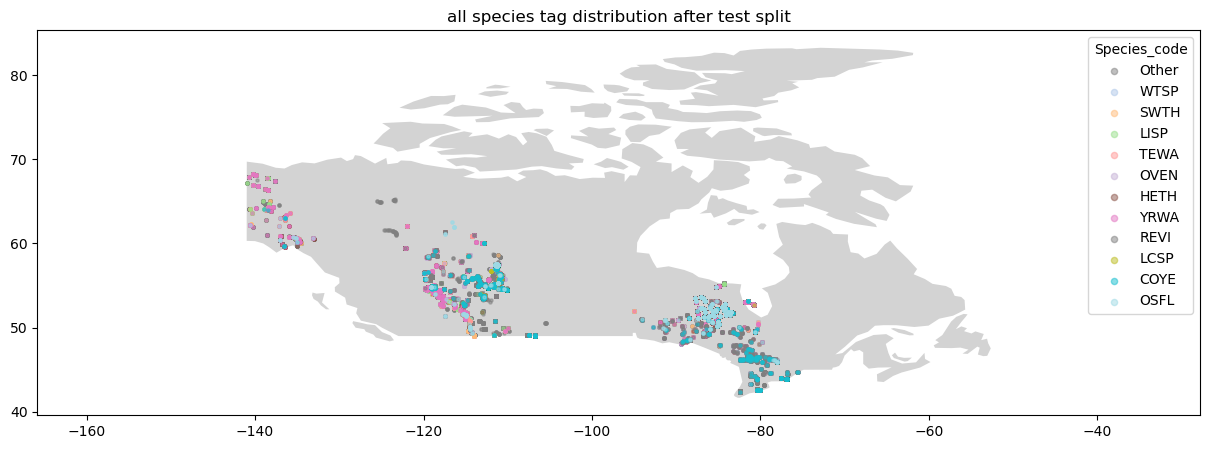

In [26]:
plot_locations(
    df_test,
    "species_code",
    title="all species tag distribution after test split",
    forced_features=["OSFL"],
)

/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/src/utils.py:50: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  canada = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres")).query(
/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/src/utils.py:74: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  points.plot(
/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/src/utils.py:74: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  points.plot(


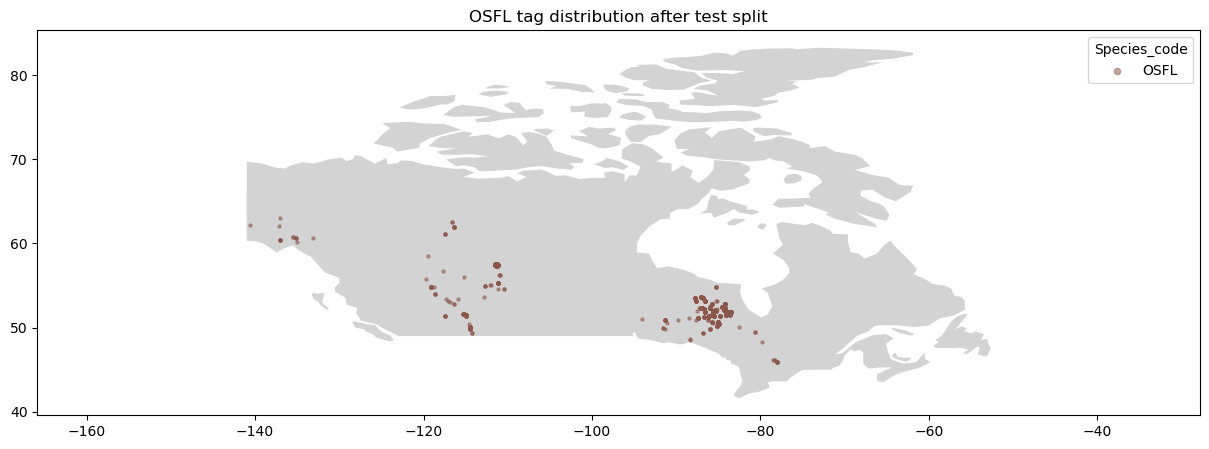

In [27]:
plot_locations(
    osfls_test, title="OSFL tag distribution after test split", feature="species_code"
)

In [28]:
df_test.loc[df.species_code == "OSFL"].species_code.value_counts()

species_code
OSFL    777
Name: count, dtype: int64

# Splitting by location id has produced a test set with the spatial distributions shown above. 
- The three main clusters are all represented. 
- There is an especially high number of tags generated by the Birds Of James Bay Lowlands projects in Ontario. This seems like the largest single cluster. 
- Splitting at the recording by 20% level aslo returned roughly 20% of the OSFL tags.

The birds of james bay lowlands and boreal shield tags are clustered roughly between longitudes of -90 and -85, and between lattitudes of 50 and 55. 

/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/src/utils.py:50: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  canada = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres")).query(
/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/src/utils.py:74: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  points.plot(
/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/src/utils.py:74: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  points.plot(


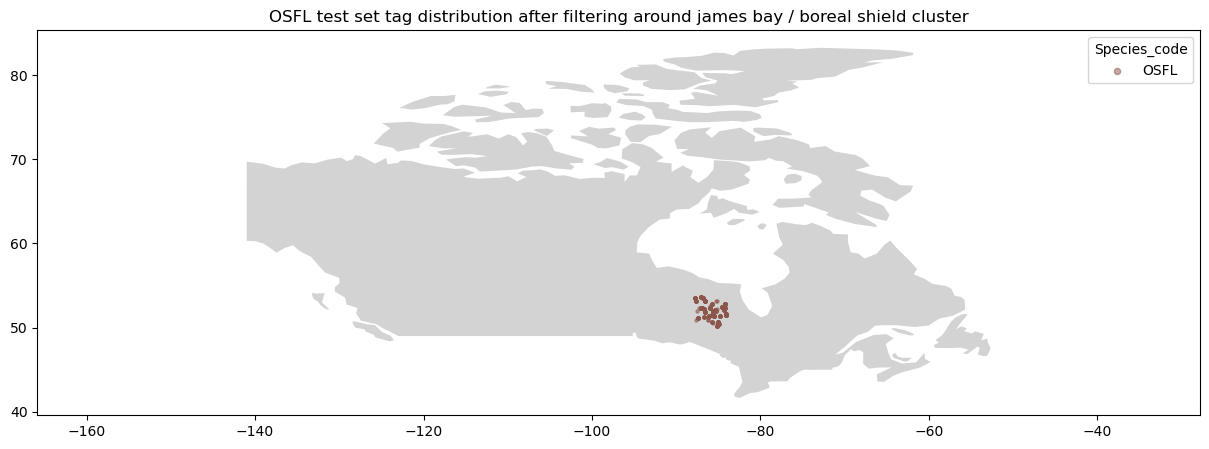

Total osfl tags in test set: 416, Total osfl tags in this region: 777


0.5353925353925354

In [29]:
# filter out the james bay cluster by lat long to get a rough count.
lonmin = -88
lonmax = -84
latmin = 50
latmax = 54
lon_filt = osfls_test.loc[osfls_test.longitude < lonmax].loc[
    osfls_test.longitude > lonmin
]
james_bay_osfls = lon_filt.loc[lon_filt.latitude < latmax].loc[
    lon_filt.latitude > latmin
]
plot_locations(
    james_bay_osfls,
    title="OSFL test set tag distribution after filtering around james bay / boreal shield cluster",
    feature="species_code",
)
print(
    f"Total osfl tags in test set: {len(james_bay_osfls)}, Total osfl tags in this region: {len(osfls_test)}"
)
len(james_bay_osfls) / len(osfls_test)

Checking the same region via the two most active projects in this area:


In [30]:
osfls_test.project.value_counts()[:5]

project
CWS-Ontario Birds of James Bay Lowlands 2021          235
CWS-Ontario Boreal Shield-Lowlands Transition 2022    214
Boreal Wetland Community Monitoring                   128
Bayne-OSFL-BU-AnyYr 2021                               43
Big Grids                                              26
Name: count, dtype: int64

/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/src/utils.py:50: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  canada = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres")).query(
/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/src/utils.py:74: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  points.plot(
/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/src/utils.py:74: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  points.plot(


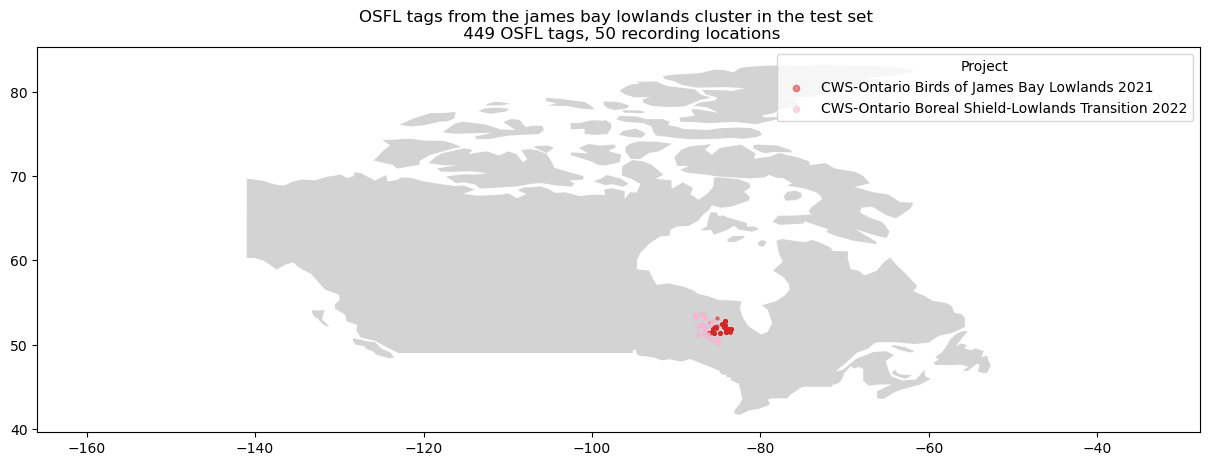

In [31]:
james_bay_projects = [
    "CWS-Ontario Birds of James Bay Lowlands 2021",
    "CWS-Ontario Boreal Shield-Lowlands Transition 2022",
]
number_of_osfl_tags = len(osfls_test[osfls_test.project.isin(james_bay_projects)])
unique_recording_locations = len(
    osfls_test[osfls_test.project.isin(james_bay_projects)].location_id.unique()
)

plot_locations(
    osfls_test[osfls_test.project.isin(james_bay_projects)],
    title=f"OSFL tags from the james bay lowlands cluster in the test set \n {number_of_osfl_tags} OSFL tags, {unique_recording_locations} recording locations",
)

In [32]:
percent_of_total_tags_in_jamesbay = len(
    df.loc[df.project.isin(james_bay_projects)]
) / len(df)
percent_of_osfl_tags_in_jamesbay = len(
    osfls.loc[osfls.project.isin(james_bay_projects)]
) / len(osfls)
print(f"Percent of total tags in james bay: {percent_of_total_tags_in_jamesbay}")
print(f"Percent of total osfl tags in james bay: {percent_of_osfl_tags_in_jamesbay}")

Percent of total tags in james bay: 0.1789854575705305
Percent of total osfl tags in james bay: 0.5661837666203612


# Thoughs about splitting the test by taking 20% by recording location:
- This method provides a guarantee that the model is being evaluated on how well it performs in new locations, since none of the locations in the training set are present in the test set. 
- There is a spatial skew in the data: about 50% of all the olive sided flycatcher tags collected in the database come form two projects centered around the james bay lowland's area and the boreal shield.
- This distribution is true of the test set and of the training set, so the criteria that the test set is representative of the training data is met. 
- The intedned use location of this model is in BC, which is outside of the three regions where most of the data has been collected so far. To develop a test for how well the model will perform in locations far away from the test data, one strategy would be to remove all the Yukon data from the training dataset, then to include these data during testing. This would give a proxy for how the model performns on data from outside the region of training data collection. 
- Unfortunately, 100% of the data collected in the Yukon was recorded as mp3 files, so by splitting the training and test set in this way, we would also end up testing how the model performs on mp3 encoded audio. (the other two main areas have both flac and mp3 recordings in roughly equal quantities). This would mean that any reduction in performance might be due to encoding rather than  location. 

In [33]:
# Save the test df and the training df to file
df_test.to_pickle(data_path / "interim" / "test_set.pkl")
df_train.to_pickle(data_path / "interim" / "train_set.pkl")